In [44]:
#dependencies
import h5py
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
# Model Parameters
nneurons = 100
patchsize = 16

#noise - these Prateek is interested in changing to removed iid asumption
noisexsigma = 0.4
noisersigma = 2

lambdaj = 0.1 #this is adjusted in order to get ravg = 1
ravg = 1

batchsize = 100
iterations = int(1e6)

In [56]:
#full images
#vhims = extract_images('../vanHaterenNaturalImages/VanHaterenNaturalImagesCurated.h5')

#image patches (as in Karklin& Simoncelli)
vhims = vanHateren(
    img_dir='../vanHaterenNaturalImages/VanHaterenNaturalImagesCurated.h5',
    normalize = True,
    patch_edge_size=patchsize
    )

normalizing...
sectioning into patches....


In [55]:
def extract_images(filename):
    #function from Dylan
    with h5py.File(filename, "r") as f:
        full_img_data = np.array(f['van_hateren_good'], dtype=np.float32)
    return full_img_data

class vanHateren:
    def __init__(self,
                 img_dir,
                 patch_edge_size=None,
                 normalize=False,
                 rand_state=np.random.RandomState()):
        self.images = self.extract_images(img_dir, patch_edge_size, normalize)

    """
    adapted from Dylan Payton's code for Sparse coding here: https://github.com/dpaiton/FeedbackLCA/blob/master/data/input_data.py
    load in van hateren dataset
    if patch_edge_size is specified, rebuild data array to be of sequential image
    patches.
    if preprocess is true, subtract mean from each full-size image, and rescale image variance to 1
    Note: in K&S2011, methods report input images' piel values were 'linear with respect to light intensity'
    I'm not sure if this is true for the VH images we are using, and how to properly normalize for this if not.
    """

    def extract_images(self, filename, patch_edge_size=None, normalize=False):
        with h5py.File(filename, "r") as f:
            full_img_data = np.array(f['van_hateren_good'], dtype=np.float32)
            if(normalize):
                print('normalizing...')
                full_img_data = full_img_data - np.mean(full_img_data,axis=(1,2),keepdims=True)
                full_img_data = full_img_data/np.std(full_img_data,axis=(1,2),keepdims=True)
            if patch_edge_size is not None:
                print('sectioning into patches....')
                (num_img, num_px_rows, num_px_cols) = full_img_data.shape
                num_img_px = num_px_rows * num_px_cols
                assert np.sqrt(num_img_px) % patch_edge_size == 0, ("The number of image edge pixels % the patch edge size must be 0.")
                self.num_patches = int(num_img_px / patch_edge_size**2)
                full_img_data = np.reshape(full_img_data, (num_img, num_img_px))
                data = np.vstack([full_img_data[idx,...].reshape(self.num_patches, patch_edge_size, patch_edge_size) for idx in range(num_img)])
            else:
                data = full_img_data
                self.num_patches = 0
            return data


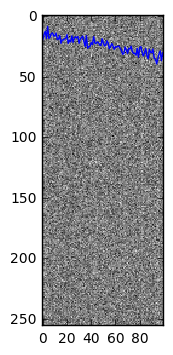

In [64]:
#input image
x = tf.placeholder(tf.float32, shape=(patchsize**2,1),name='input_image')
#noise
nx = tf.placeholder(tf.float32, shape=(patchsize**2,1),name='input_noise')
nr = tf.placeholder(tf.float32, shape=(nneurons,1),name='response_noise')

#weights
w = tf.Variable(tf.random_normal(shape=(patchsize**2,nneurons),stddev=1),name='weights')
#relu params
reluslope = tf.Variable(tf.random_normal((nneurons,1),stddev=1),name='relu_slope')
reluoff = tf.Variable(tf.random_normal((nneurons,1),stddev=1),name='relu_offset')

#calculate response
y = tf.transpose(tf.matmul(tf.transpose(x + nx),w))
r = tf.add(reluslope * tf.nn.relu(y + reluoff), nr)

#objective function: maximize I(X,R)-sum_j(lambda*<r_j>)
mask = tf.cast(tf.less(tf.zeros((nneurons,1))+reluoff,y),tf.float32)
g = tf.diag(tf.reshape(tf.multiply(reluslope,mask),[100]))
#print(reluoff.get_shape())
#print(y.get_shape())
#print(mask.get_shape())
#print(tf.multiply(reluslope,mask).get_shape())

cx = tf.matmul(tf.transpose(x), x)
cnr = tf.matmul(nr,tf.transpose(nr))
cnx = tf.matmul(nx,tf.transpose(nx))

cxr = tf.matrix_inverse(tf.matrix_inverse(cx) + #with inverse calculated by Shariq
#cxr =  1 * (tf.matrix_inverse(cx) + #as in paper
                        tf.matmul(w, 
                        tf.matmul(g, 
                        tf.matmul(tf.matrix_inverse(
                        tf.matmul(g,
                        tf.matmul(tf.transpose(w), 
                        tf.matmul(cnx, 
                        tf.matmul(w, g)))) + cnr),
                        tf.matmul(g, tf.transpose(w))))))

cxr = tf.div(cxr,tf.reduce_max(cxr)) #scale to make determinant smaller


information = tf.reduce_mean(0.5*tf.log(2*np.pi*np.exp(1)*(tf.matrix_determinant(cxr)+0.01)))
objective =  information - tf.reduce_sum(lambdaj * tf.reduce_mean(r,1))#/nneurons

train_step = tf.train.GradientDescentOptimizer(0.001).minimize(-objective)

#run it!
with tf.Session() as sess:
    #initialize vars
    init = tf.global_variables_initializer()
    sess.run(init)
    objectives = []
    for ii in range(10000):
        #image = np.random.rand(patchsize**2,1).astype(np.float32) #random image
        i = np.reshape(vhims.images[ii,:,:],(patchsize**2,1))
        noise_input = np.random.rand(patchsize**2,1).astype(np.float32)
        noise_response = np.random.rand(nneurons,1).astype(np.float32)
        #train_step.run(feed_dict={x:image, nx: noise_input, nr:noise_response})
        sess.run(train_step, feed_dict={x:image, nx: noise_input, nr:noise_response})
        cost = sess.run(objective, feed_dict={x:image, nx: noise_input, nr:noise_response})
        objectives.append(cost)
    #print statements
    #myweights = w.eval()
    #print(myweights)
    #myrlus = reluslope.eval()
    #print(myrlus)
    #myrluof = reluoff.eval()
    #print(myrluof)
    #myrs = r.eval()
    #print(myrs)
    #myobjective = objective.eval()
    #print(myobjective)
    weights = sess.run(w, feed_dict={x:image, nx: noise_input, nr:noise_response})

plt.plot(objectives)
plt.imshow(weights,cmap='gray',interpolation='none')